# Residential location choice

We will calculate spacial equilibrium numerically for the simplest setup of the model---i.e., the one with homogeneous consumers and homogenous space. 

Let's start by reviewing the main equations that we will use to compute the equilibrium. First, the consumers' utility maximization problem is
\begin{align*}
&\max\limits_{s,c}\{u(c,s)\}\\
&pc+r(x)s = y-tx
\end{align*}
Since we are interested in individual demand for land, we can use budget constrain to exclude consumption from the problem:
\begin{equation*}
s^{\ast}(r(x),p,y,x) = \arg\max\limits_{s}\left\{u\left(\frac{y-tx-r(x)s}{p},s \right)\right\}
\end{equation*}

The condition that the indirect utility must be indepenent of the location (otherwise, some locations will not be populated in equilibrium) gives us the equation that disciplines the difference in prices between two locations:
\begin{equation*}
\frac{d}{dx}r(x) = -\frac{t}{s^{\ast}(r(x),p,y,x)}
\end{equation*}
or in the integral form
\begin{equation*}
r(x)-r(0) = -\int\limits_{0}^{x}\frac{tdz}{s^{\ast}(r(z),p,y,z)}
\end{equation*}

The endogenous city boundary $x_B$ solves $r(x_B) = r_A$. The integral equation pins down prices at all locations except $x = 0$. In order to find the price in the center we solve the market clearing condition for land:
\begin{equation*}
N = \int\limits_{0}^{x_B}\frac{2\pi z dz}{s^{\ast}(r(z),p,y,z)}
\end{equation*}

### Algorithm

We will use the following algorithm for computing the equilibrium:
1. For given prices we compute the individual demand for land.
2. Using the integral equation we compute the land prices.
3. Iterate 1. and 2. until the prices that we use as input coincide with the prices that solve the integral equation.
4. Solve the market clearing condition for $r(0)$.

We cannot work with the continuum of locations directly, so we will intoduce a deterministic location grid with a small increment.  

We begin by defining consumer's preferences. In this example we will use Cobb-Duglas utility, but the script works for arbitrary utility functions (as long as the assumptions used in the model are satisfied).

In [2]:
function utilityfn(c,s)
#Utility function()
alpha = 0.3
rslt = (c.^alpha).*(s.^(1-alpha))
end;

Now we can solve the utility maximization problem. Inputs for this problem are transportation costs $t$ (variable `trc`), income $y$ (variable `income`), the price of consumption good $p$ (variable `p`), the discreet grid on the set of locations (variable `xx`) and the land prices (variable `rr`). Naturally, variables `rr` and `xx` should have the same dimensions. Function `dmnd` solves for demanded consumption and land for each location (so the outpus will be vectors with the same dimensions as `xx`) given inputs.

In [3]:
# using Pkg
# Pkg.add("Optim")
using Optim

function dmnd(trc, income, p, xx, rr)
#demand
nn = length(xx)
s_temp = zeros(nn,1)
c_temp = zeros(nn,1)
for ii in 1:nn
    utilityfn_lambda(s) = -utilityfn((income-trc*xx[ii]-rr[ii]*s)/p,s)
    s_temp[ii,1] = Optim.minimizer(optimize(utilityfn_lambda,0,max(0,(income-trc*xx[ii])/rr[ii])))
    c_temp[ii,1] = (income-trc*xx[ii]-rr[ii]*s_temp[ii,1])/p
end
s_dmnd = s_temp
c_dmnd = c_temp
return (c_dmnd, s_dmnd)
end;

Once we have individual demand functions, we can solve the integral equation for land prices. We will iterate 1. and 2. until we arrive at the solution: this iterations are implemented in the `while` loop. Note that the prices in the iterations are updated with some inertia (see `rr_old = (rr_old+rr_new)/2`). This is a heuristic to obtain the convergence of the iterations. The function `findrent` below finds prices $r(x)$ given the price in the center $r(0)$ (we will solve for it later).

In [4]:
function findrent(trc, income, p, r_A, xx, r0)
#search for the solution to dr/dx = -t/s[r]

toler1 = 0.001 #this is a precision parameter for iterations on r(x)
nn = length(xx)
drr = 12345.0
rr_old = fill(r0, nn, 1)#r0*ones(length(xx),1)
rr_new = rr_old.+drr


while drr>toler1
    (c_dmnd, s_dmnd) = dmnd(trc, income, p, xx, rr_old)
    rr_new[1] = r0
    for ii in 2:nn
        if s_dmnd[ii] > 0
            rr_new[ii] = max(rr_new[ii-1]-trc*(xx[ii]-xx[ii-1])/s_dmnd[ii] , 0)
        else
            rr_new[ii] = 0
        end
    end
    drr = maximum(abs.(rr_new-rr_old), dims=1)[1]
    #println(drr)
    rr_old = (rr_old+rr_new)/2
end

return rr_new

        end;

Finally, we can use market clearing condition to solve for $r(0)$. We use the binary search since we know that excess demand is monotone in $r(0)$. The first `while` look finds $r(0)$ large enough for the excess demand to be negative (recall, that this value is required to start the binary search). the second `while` loop solves the market clearing condition.

In [5]:
function findeq(trc, income, p, r_A, xx, N)
toler2 = 0.0001
rr = similar(xx)
dxx = similar(xx)
dxx[1] = 0
dxx[2:end] = xx[2:end]-xx[1:end-1]
xxdxx = xx.*dxx


r0h = 0.0 # this value must be low enough otherwise the solution will not be found
r0l = 0.0
rhs = 0.0 # arbitrary value less than N

#Find the rough bound on r(0) that result in excess supply and excess demand for land
while rhs[1]<N
    r0l = r0h
    r0h = 2*r0h+0.1
    rr = findrent(trc, income, p, r_A, xx, r0h)
    ii_B = argmin(abs.(rr.-r_A), dims=1)[1][1]
    (c_dmnd, s_dmnd) = dmnd(trc, income, p, xx, rr)
    rhs_mat = 2*pi*xxdxx./s_dmnd
    rhs = sum(rhs_mat[1:ii_B], dims=1)
    println("Right hand side is $rhs")
end

#r0l = 0
r0 = r0l
rhs = 0.0

while abs(r0h-r0l)>toler2
    if rhs[1]>N
        r0h = r0
    else()
        r0l = r0
    end
    r0 = (r0h+r0l)/2
    rr = findrent(trc, income, p, r_A, xx, r0)
    ii_B = argmin(abs.(rr.-r_A), dims=1)[1][1]
    (c_dmnd, s_dmnd) = dmnd(trc, income, p, xx, rr)
    rhs_mat = 2*pi*xxdxx./s_dmnd
    rhs = sum(rhs_mat[1:ii_B], dims=1)
    println("$r0l $r0h")
end

return rr

end;
    
function compute_welfare(trc, income, p, xx, r_A, rr)
    (c_dmnd, s_dmnd) = dmnd(trc, income, p, xx, rr)
    V = utilityfn(c_dmnd[1],s_dmnd[1])
    dxx = copy(xx)
    dxx[1] = 0
    dxx[2:end] = xx[2:end]-xx[1:end-1]
    xxdxx = xx.*dxx
    WW = 2*pi*xxdxx.*(rr.-r_A)
    W = sum(WW[1:ii_B])
    println("====================================")
    println("utility:       $V")
    println("value of land: $W")
    end;

Once all this functions are defined we can run them on some parameters. For instance, we can set
\begin{align*}
&t = 1\\
&y = 5\\
&p = 1\\
&r_A = 0.1\\
&N = 20
\end{align*} and run the code to compute the prices.

In [6]:
#define exogenous parameters
trc = 1.0
income = 5.0
p = 1.0
r_A = 0.1
N = 10.0

#define set of locations (discretization)
grid_size = 300
maxX = income/trc
xx = [(maxX/grid_size)*(ii-1) for ii in (1:grid_size)]

#compute equilibrium
rr_bid = findeq(trc, income, p, r_A, xx, N)
r_A_mat = r_A*ones(length(xx),1)
rr = maximum([rr_bid r_A_mat], dims=2)
ii_B = argmin(abs.(rr_bid.-r_A), dims=1)[1][1]
border_x = xx[ii_B]
#compute welfare
compute_welfare(trc, income, p, xx, r_A, rr)

Right hand side is [0.0]
Right hand side is [1.60608]
Right hand side is [6.40852]
Right hand side is [16.615]
0.7000000000000001 1.5000000000000002
0.7000000000000001 1.1
0.9000000000000001 1.1
0.9000000000000001 1.0
0.9500000000000001 1.0
0.9750000000000001 1.0
0.9750000000000001 0.9875
0.9812500000000001 0.9875
0.9812500000000001 0.984375
0.9812500000000001 0.9828125000000001
0.9812500000000001 0.9820312500000001
0.9812500000000001 0.981640625
0.9812500000000001 0.9814453125
0.9812500000000001 0.9813476562500001
utility:       2.7505156009621485
value of land: 12.409670238478299


Now we can use the output to plot a graph of $r(x)$.

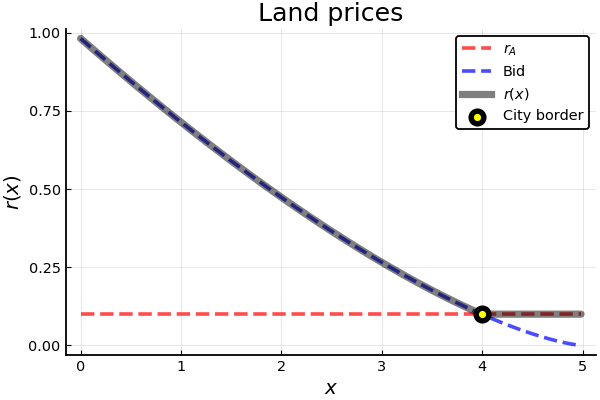

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


In [8]:
# using Pkg
# Pkg.add("Plots")
using Plots
pyplot()
# using Pkg
# Pkg.add("LaTeXStrings")
using LaTeXStrings

plot(xx, r_A_mat,
        seriestype = :line,
        linestyle = :dash,
        linealpha = 0.7,
        linewidth = 2,
        linecolor = :red,
        label = L"r_A")
xlabel!(L"x")
ylabel!(L"r(x)")
title!("Land prices")
plot!(xx, rr_bid,
        seriestype = :line,
        linestyle = :dash,
        linealpha = 0.7,
        linewidth = 2,
        linecolor = :blue,
        label = "Bid")
plot!(xx, rr,
        seriestype = :line,
        linestyle = :solid,
        linealpha = 0.5,
        linewidth = 4,
        linecolor = :black,
        label = L"r(x)")
scatter!([border_x], [r_A],
        markershape = :circle,
        markersize = 8,
        markeralpha =1,
        markercolor = :yellow,        
        markerstrokewidth = 3,
        markerstrokealpha = 1,
        markerstrokecolor = :black,
        markerstrokestyle = :solid,
    #    dpi = 180,
    #    size = (1200,800),
        thickness_scaling = 1.3,
        label = "City border")